In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

from scipy.cluster.hierarchy import single

from AlignAIR.Utilities.step_utilities import DataConfigLibrary

sns.set_context('poster')
mpl.rcParams['figure.figsize'] = (20,11)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['grid.alpha'] = 1
mpl.rcParams['grid.linewidth'] = 1

In [2]:
import argparse
import logging
import yaml
import questionary
import tensorflow as tf
from AlignAIR.PostProcessing.Steps.allele_threshold_step import MaxLikelihoodPercentageThresholdApplicationStep, \
    ConfidenceMethodThresholdApplicationStep
from AlignAIR.PostProcessing.Steps.clean_up_steps import CleanAndArrangeStep
from AlignAIR.PostProcessing.Steps.correct_likelihood_for_genotype_step import GenotypeBasedLikelihoodAdjustmentStep
from AlignAIR.PostProcessing.Steps.finalization_and_packaging_steps import FinalizationStep
from AlignAIR.PostProcessing.Steps.germline_alignment_steps import AlleleAlignmentStep
from AlignAIR.PostProcessing.Steps.segmentation_correction_steps import SegmentCorrectionStep
from AlignAIR.PostProcessing.Steps.translate_to_imgt_step import TranslationStep
from AlignAIR.PredictObject.PredictObject import PredictObject
from AlignAIR.Preprocessing.Steps.batch_processing_steps import BatchProcessingStep
from AlignAIR.Preprocessing.Steps.dataconfig_steps import ConfigLoadStep
from AlignAIR.Preprocessing.Steps.file_steps import FileNameExtractionStep, FileSampleCounterStep
from AlignAIR.Preprocessing.Steps.model_loading_steps import ModelLoadingStep
from AlignAIR.Step.Step import Step

# Set TensorFlow logging level to ERROR
tf.get_logger().setLevel('ERROR')
class Args:
    """
       A class to convert dictionary entries to class attributes.
    """
    def __init__(self, **entries):
        self.__dict__.update(entries)


C:\Users\tomas\Desktop\AlignAIR\AlignAIR_ENV\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [83]:
import argparse
"""
Here we load all the parameters needed for using the complete AlignAIR suite, including the post-processing and pre-processing steps.
This is usually done via Docker or CLI, thus we imitate the parameters one would pass in the command line and load all of them into an argparse namespace.
"""

args = argparse.Namespace(
    mode=None,
    config_file='',# this is for the YAML file mode and is not relevant here,
    model_checkpoint=r'C:\Users\tomas\Desktop\AlignAIRR\tests\AlignAIRR_S5F_OGRDB_V8_S5F_576_Balanced_V2', # check point of trained model weights
    save_path='/Users/tomas/Downloads/', # path for the saved results
    chain_type='heavy', # type of chain i.e heavy/light
    sequences=r'C:\Users\tomas\Desktop\AlignAIRR\tests\sample_HeavyChain_dataset.csv', # the target sequences, can be csv/tsv/FASTA file, csv and tsv must have a column called "sequecne"
    lambda_data_config='D', # if custom lambda dataconfig is required else leave as "D"
    kappa_data_config='D', # if custom kappa dataconfig is required else leave as "D"
    heavy_data_config='D', # if custom heavy chain dataconfig is required else leave as "D"
    max_input_size=576, # max input size, has to match the max_size of the trained model
    batch_size=8, # the maximum number of samples per batch processed by the model
    v_allele_threshold=0.1, # the threshold for v allele call likelihood consideration
    d_allele_threshold=0.1, # the threshold for d allele call likelihood consideration
    j_allele_threshold=0.1, # the threshold for j allele call likelihood consideration
    v_cap=3, # the maximum number of v allele calls the model will select based on the likelihood predicted and the threshold
    d_cap=3, # the maximum number of d allele calls the model will select based on the likelihood predicted and the threshold
    j_cap=3, # the maximum number of j allele calls the model will select based on the likelihood predicted and the threshold
    translate_to_asc=True, # in case ASC were derived for the DataConfig, this will transalte the ASC's to IMGT allele names
    fix_orientation=True, # this flag controls wheter the preprocessing should check if there are reversed sequences and orient them properly
    custom_orientation_pipeline_path=None ,# in case you have a custom model you will need to create a custom orientation pipeline, and specify the path here
    custom_genotype=None,
    finetuned_model_params_yaml=None
)

In [4]:
MODEL_CHECKPOINT = r'C:/Users/tomas/Desktop/AlignAIR/tests/AlignAIRR_S5F_OGRDB_V8_S5F_576_Balanced_V2'


# Loading The Model

In [5]:
from AlignAIR.Data import HeavyChainDataset
from GenAIRR.data import builtin_heavy_chain_data_config

dataconfig_insatnce = builtin_heavy_chain_data_config() # make sure the dataconfig you are using matches your dataset (the alleles in your dataset should share the same reference for the V,D and J alleles as the dataconfig object)
heavy_chain_dataset_path = r'C:/Users/tomas/Desktop/AlignAIR/tests/sample_HeavyChain_dataset.csv'
train_dataset = HeavyChainDataset(data_path=heavy_chain_dataset_path,
                                          dataconfig=dataconfig_insatnce ,batch_read_file=True,
                                          max_sequence_length=576)

In [7]:
from AlignAIR.Models.HeavyChain import HeavyChainAlignAIRR
from AlignAIR.Trainers import Trainer

dataconfig_= builtin_heavy_chain_data_config()
max_sequence_length = 576
v_allele_count = len([i for j in dataconfig_.v_alleles for i in dataconfig_.v_alleles[j]])
d_allele_count = len([i for j in dataconfig_.d_alleles for i in dataconfig_.d_alleles[j]])+1
j_allele_count = len([i for j in dataconfig_.j_alleles for i in dataconfig_.j_alleles[j]])

trainer = Trainer(
    model=HeavyChainAlignAIRR(
        max_seq_length=max_sequence_length,
        v_allele_count=v_allele_count,
        d_allele_count=d_allele_count,
        j_allele_count=j_allele_count
    ),
    epochs=1,
    steps_per_epoch=512,
    batch_size=8,
    verbose=1,
    classification_metric=[tf.keras.metrics.AUC(), tf.keras.metrics.AUC(), tf.keras.metrics.AUC()],
    regression_metric=tf.keras.losses.binary_crossentropy,
    pretrained_path=MODEL_CHECKPOINT,
    max_seq_length=max_sequence_length
)


tanh
Model built with input shape: (576,1)
Model weights loaded from C:/Users/tomas/Desktop/AlignAIR/tests/AlignAIRR_S5F_OGRDB_V8_S5F_576_Balanced_V2.


In [15]:
from AlignAIR.PostProcessing.Steps.allele_threshold_step import MaxLikelihoodPercentageThresholdApplicationStep, \
    ConfidenceMethodThresholdApplicationStep
from AlignAIR.PostProcessing.Steps.clean_up_steps import CleanAndArrangeStep
from AlignAIR.PostProcessing.Steps.finalization_and_packaging_steps import FinalizationStep
from AlignAIR.PostProcessing.Steps.germline_alignment_steps import AlleleAlignmentStep
from AlignAIR.PostProcessing.Steps.segmentation_correction_steps import SegmentCorrectionStep
from AlignAIR.PostProcessing.Steps.translate_to_imgt_step import TranslationStep
from AlignAIR.PredictObject.PredictObject import PredictObject
from AlignAIR.Preprocessing.Steps.batch_processing_steps import BatchProcessingStep
from AlignAIR.Preprocessing.Steps.dataconfig_steps import ConfigLoadStep
from AlignAIR.Preprocessing.Steps.file_steps import FileNameExtractionStep, FileSampleCounterStep
from AlignAIR.Preprocessing.Steps.model_loading_steps import ModelLoadingStep
import logging
from AlignAIR.Step.Step import Step
# create a logger to log the process
logger = logging.getLogger('PipelineLogger')
Step.set_logger(logger)

# set up t he predict objecet, here all the predicted information and processed results will be saved
predict_object = PredictObject(args, logger=logger)

# define the steps in the prediction pipeline
steps = [
    ModelLoadingStep('Load Models'),
    BatchProcessingStep("Process and Predict Batches"),
    CleanAndArrangeStep("Clean Up Raw Prediction"),
    SegmentCorrectionStep("Correct Segmentations"),
    MaxLikelihoodPercentageThresholdApplicationStep("Apply Max Likelihood Threshold to Distill Assignments"),
    AlleleAlignmentStep("Align Predicted Segments with Germline"),
    TranslationStep("Translate ASC's to IMGT Alleles"),
    FinalizationStep("Finalize Post Processing and Save Csv")
]

#run the pipeline
for step in steps:
    predict_object = step.execute(predict_object)

AttributeError: 'PredictObject' object has no attribute 'file_info'

In [101]:
from AlignAIR.Data.PredictionDataset import PredictionDataset
from AlignAIR.Utilities.step_utilities import DataConfigLibrary
from IPython.display import clear_output
class SingleInstancePredictor:
    def __init__(self,model):
        self.model = model

        self.steps = [
            CleanAndArrangeStep("Clean Up Raw Prediction"),
            SegmentCorrectionStep("Correct Segmentations"),
            MaxLikelihoodPercentageThresholdApplicationStep("Apply Max Likelihood Threshold to Distill Assignments"),
            AlleleAlignmentStep("Align Predicted Segments with Germline"),
            TranslationStep("Translate ASC's to IMGT Alleles"),
        ]

        self.finalization_step =  FinalizationStep("Finalize Post Processing and Save Csv")


        self.encoder = PredictionDataset(max_sequence_length=576)

    def _format_output(self,predict_object):
        cleaned_data = predict_object.processed_predictions
        germline_alignments = predict_object.germline_alignments

        sequences = predict_object.sequences

        # Compile results into a DataFrame
        final_csv = pd.DataFrame({
            'sequence': sequences,
            'v_call': [','.join(i) for i in predict_object.selected_allele_calls['v']],
            'j_call': [','.join(i) for i in predict_object.selected_allele_calls['j']],
            'v_sequence_start': [i['start_in_seq'] for i in predict_object.germline_alignments['v']],
            'v_sequence_end': [i['end_in_seq'] for i in predict_object.germline_alignments['v']],
            'j_sequence_start': [i['start_in_seq'] for i in predict_object.germline_alignments['j']],
            'j_sequence_end': [i['end_in_seq'] for i in predict_object.germline_alignments['j']],
            'v_germline_start': [max(0, i['start_in_ref']) for i in predict_object.germline_alignments['v']],
            'v_germline_end': [i['end_in_ref'] for i in predict_object.germline_alignments['v']],
            'j_germline_start': [max(0, i['start_in_ref']) for i in predict_object.germline_alignments['j']],
            'j_germline_end': [i['end_in_ref'] for i in predict_object.germline_alignments['j']],
            'v_likelihoods': predict_object.likelihoods_of_selected_alleles['v'],
            'j_likelihoods': predict_object.likelihoods_of_selected_alleles['j'],
            'mutation_rate': predict_object.processed_predictions['mutation_rate'],
            'ar_indels': predict_object.processed_predictions['indel_count'],
            'ar_productive': predict_object.processed_predictions['productive'],
        })

        if predict_object.data_config_library.mounted == 'heavy':
            final_csv['d_sequence_start'] = [i['start_in_seq'] for i in predict_object.germline_alignments['d']]
            final_csv['d_sequence_end'] = [i['end_in_seq'] for i in predict_object.germline_alignments['d']]
            final_csv['d_germline_start'] = [abs(i['start_in_ref']) for i in predict_object.germline_alignments['d']]
            final_csv['d_germline_end'] = [i['end_in_ref'] for i in predict_object.germline_alignments['d']]
            final_csv['d_call'] = [','.join(i) for i in predict_object.selected_allele_calls['d']]
            final_csv['d_likelihoods'] = predict_object.likelihoods_of_selected_alleles['d']
            final_csv['type'] = 'heavy'
        else:
            final_csv['type'] = ['kappa' if i == 1 else 'lambda' for i in predict_object.processed_predictions['type_'].astype(int).squeeze()]

        return final_csv

    def predict(self,sequence):
        encoded = self.encoder.encode_and_equal_pad_sequence(sequence)
        encoded['tokenized_sequence'] = np.expand_dims(encoded['tokenized_sequence'], axis=0)
        prediction =  self.model.predict(encoded)


        predict_object = PredictObject(args, logger=logger)
        predict_object.data_config_library = DataConfigLibrary(*['D','D','D'])
        predict_object.data_config_library.mount_type('heavy')
        predict_object.sequences = [sequence]
        predict_object.raw_predictions = [prediction]


        for step in self.steps:
            predict_object = step.execute(predict_object)

        clear_output(True)
        return self._format_output(predict_object)


In [102]:
predictor = SingleInstancePredictor(trainer.model)
seq = 'NCCGCCATATTCCAGACCAGGGACTGGAGTGGGTGGCGGTTATCTCTTAGGACGGAAGTAATTCATACGGCACAGACTCCGTGAAGGGNCCATTTACCCTCTCCAGAGACCATTCCAAGAACACGCTCNGCCCACAGATGAACANCCTGAGAGGTGGGGACACGGCTGTGTCCTCTCGGGCGAGAGGATTTTTATGCCGACAGCACTTTTGATTTCTGGGGCCAAGGGACAATGGTCACCGTCTCCTCAG'
prediction = predictor.predict(seq)


1/1 [==============================] - 0s 73ms/step


Matching D Germlines: 100%|██████████| 1/1 [00:00<?, ?it/s]


# Stress Test of Noise Added To Start of Sequence / End of Sequence

In [86]:
from GenAIRR.pipeline import AugmentationPipeline
from GenAIRR.steps import AugmentationStep
from GenAIRR.utilities import DataConfig
from GenAIRR.data import builtin_heavy_chain_data_config, builtin_kappa_chain_data_config
from GenAIRR.pipeline import CHAIN_TYPE_BCR_HEAVY

# Initialize a built-in DataConfig
data_config_builtin = builtin_heavy_chain_data_config()

# Set up the data configuration and chain type for the simulations
AugmentationStep.set_dataconfig(data_config_builtin,chain_type=CHAIN_TYPE_BCR_HEAVY)

In [88]:
from GenAIRR.pipeline import AugmentationPipeline
from GenAIRR.steps import SimulateSequence, FixVPositionAfterTrimmingIndexAmbiguity
from GenAIRR.mutation import S5F
from GenAIRR.data import builtin_heavy_chain_data_config
from GenAIRR.steps.StepBase import AugmentationStep
from GenAIRR.pipeline import CHAIN_TYPE_BCR_HEAVY
from GenAIRR.steps import SimulateSequence,FixVPositionAfterTrimmingIndexAmbiguity,FixDPositionAfterTrimmingIndexAmbiguity,FixJPositionAfterTrimmingIndexAmbiguity
from GenAIRR.steps import CorrectForVEndCut,CorrectForDTrims,CorruptSequenceBeginning,InsertNs,InsertIndels,ShortDValidation,DistillMutationRate
from GenAIRR.mutation import S5F

pipeline = AugmentationPipeline([
    SimulateSequence(mutation_model = S5F(min_mutation_rate=0.003,max_mutation_rate=0.25),productive = True),
    FixVPositionAfterTrimmingIndexAmbiguity(),
    FixDPositionAfterTrimmingIndexAmbiguity(),
    FixJPositionAfterTrimmingIndexAmbiguity(),
    CorrectForVEndCut(),
    CorrectForDTrims(),
    # CorruptSequenceBeginning(corruption_probability = 0.7,corrupt_events_proba = [0.4,0.4,0.2],max_sequence_length = 576,nucleotide_add_coefficient = 210,
    #                          nucleotide_remove_coefficient = 310,nucleotide_add_after_remove_coefficient = 50,random_sequence_add_proba = 1,
    #                          single_base_stream_proba = 0,duplicate_leading_proba = 0,random_allele_proba = 0),
    #InsertNs(n_ratio = 0.02,proba = 0.5),
    ShortDValidation(short_d_length= 5),
    # InsertIndels(indel_probability = 0.5,max_indels = 5,insertion_proba=0.5,deletion_proba=0.5),
    #
    DistillMutationRate()
    ])

In [92]:
simulation =  pipeline.execute()

In [95]:
prediction.columns

Index(['sequence', 'v_call', 'j_call', 'v_sequence_start', 'v_sequence_end',
       'j_sequence_start', 'j_sequence_end', 'v_germline_start',
       'v_germline_end', 'j_germline_start', 'j_germline_end', 'v_likelihoods',
       'j_likelihoods', 'mutation_rate', 'ar_indels', 'ar_productive',
       'd_sequence_start', 'd_sequence_end', 'd_germline_start',
       'd_germline_end', 'd_call', 'd_likelihoods', 'type'],
      dtype='object')

## Shift Tests

In [168]:
source_sample = pipeline.execute()
source_prediction = predictor.predict(source_sample['sequence'])
source_prediction = source_prediction.iloc[0]
clear_output()

In [169]:
noise_levels = list(range(1,11))+[15,20,25,30,35,40,45,50]
noise_orientations  = ['start','end','both']
n_samples_per_noise = 10

simulated_samples = []
noise_ = []
orientation_ = []
for noise_level in noise_levels:
    for noise_orientation in noise_orientations:
        for _ in range(n_samples_per_noise):
            sample = source_sample.sequence
            random_dna = ''.join(np.random.choice(['A','C','G','T'],noise_level))
            random_dna2 = ''.join(np.random.choice(['A','C','G','T'],noise_level))

            if noise_orientation == 'start':
                sample = random_dna + sample
            elif noise_orientation == 'end':
                sample = sample + random_dna
            else:
                sample = random_dna + sample + random_dna2
            simulated_samples.append(sample)
            noise_.append(noise_level)
            orientation_.append(noise_orientation)


In [170]:
orientation_ = np.array(orientation_)
noise_ = np.array(noise_)

In [171]:
predictions = []
for sample in simulated_samples:
    predictions.append(predictor.predict(sample))

1/1 [==============================] - 0s 47ms/step


Matching D Germlines: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [172]:
pdf = pd.concat(predictions)

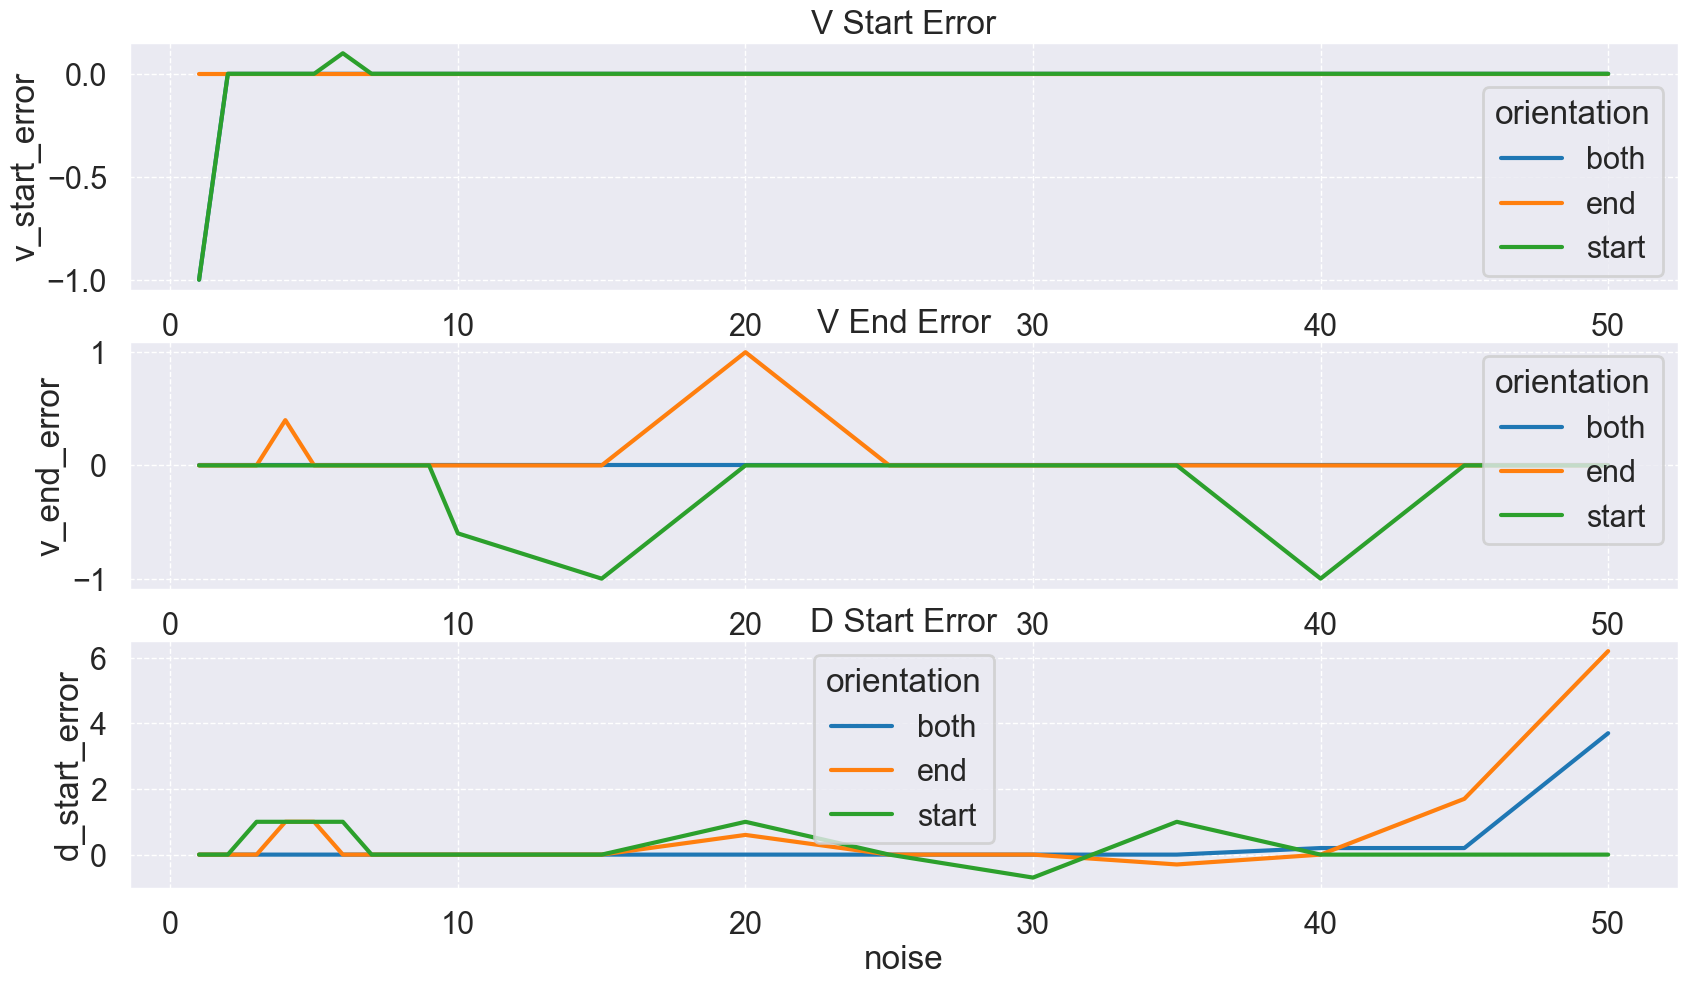

In [173]:
v_start_error = pdf['v_sequence_start'] - source_sample.v_sequence_start
v_start_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
v_start_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

v_end_error = pdf['v_sequence_end'] - source_sample.v_sequence_end
v_end_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
v_end_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']


d_start_error = pdf['d_sequence_start'] - source_sample.d_sequence_start
d_start_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
d_start_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

d_end_error = pdf['d_sequence_end'] - source_sample.d_sequence_end
d_end_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
d_end_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

j_start_error = pdf['j_sequence_start'] - source_sample.j_sequence_start
j_start_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
j_start_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

# group by noise_
error_df = pd.DataFrame({
    'v_start_error':v_start_error,
    'v_end_error':v_end_error,
    'd_start_error':d_start_error,
    'd_end_error':d_end_error,
    'j_start_error':j_start_error,

    'noise':noise_,'orientation':orientation_,


                         }).groupby(['noise','orientation']).mean()

# plot lineplot noise level vs error per orientation
plt.subplot(3,1,1)
sns.lineplot(data=error_df,x='noise',y='v_start_error',hue='orientation')
plt.title('V Start Error')
plt.subplot(3,1,2)
sns.lineplot(data=error_df,x='noise',y='v_end_error',hue='orientation')
plt.title('V End Error')
plt.subplot(3,1,3)
sns.lineplot(data=error_df,x='noise',y='d_start_error',hue='orientation')
plt.title('D Start Error')
plt.show()

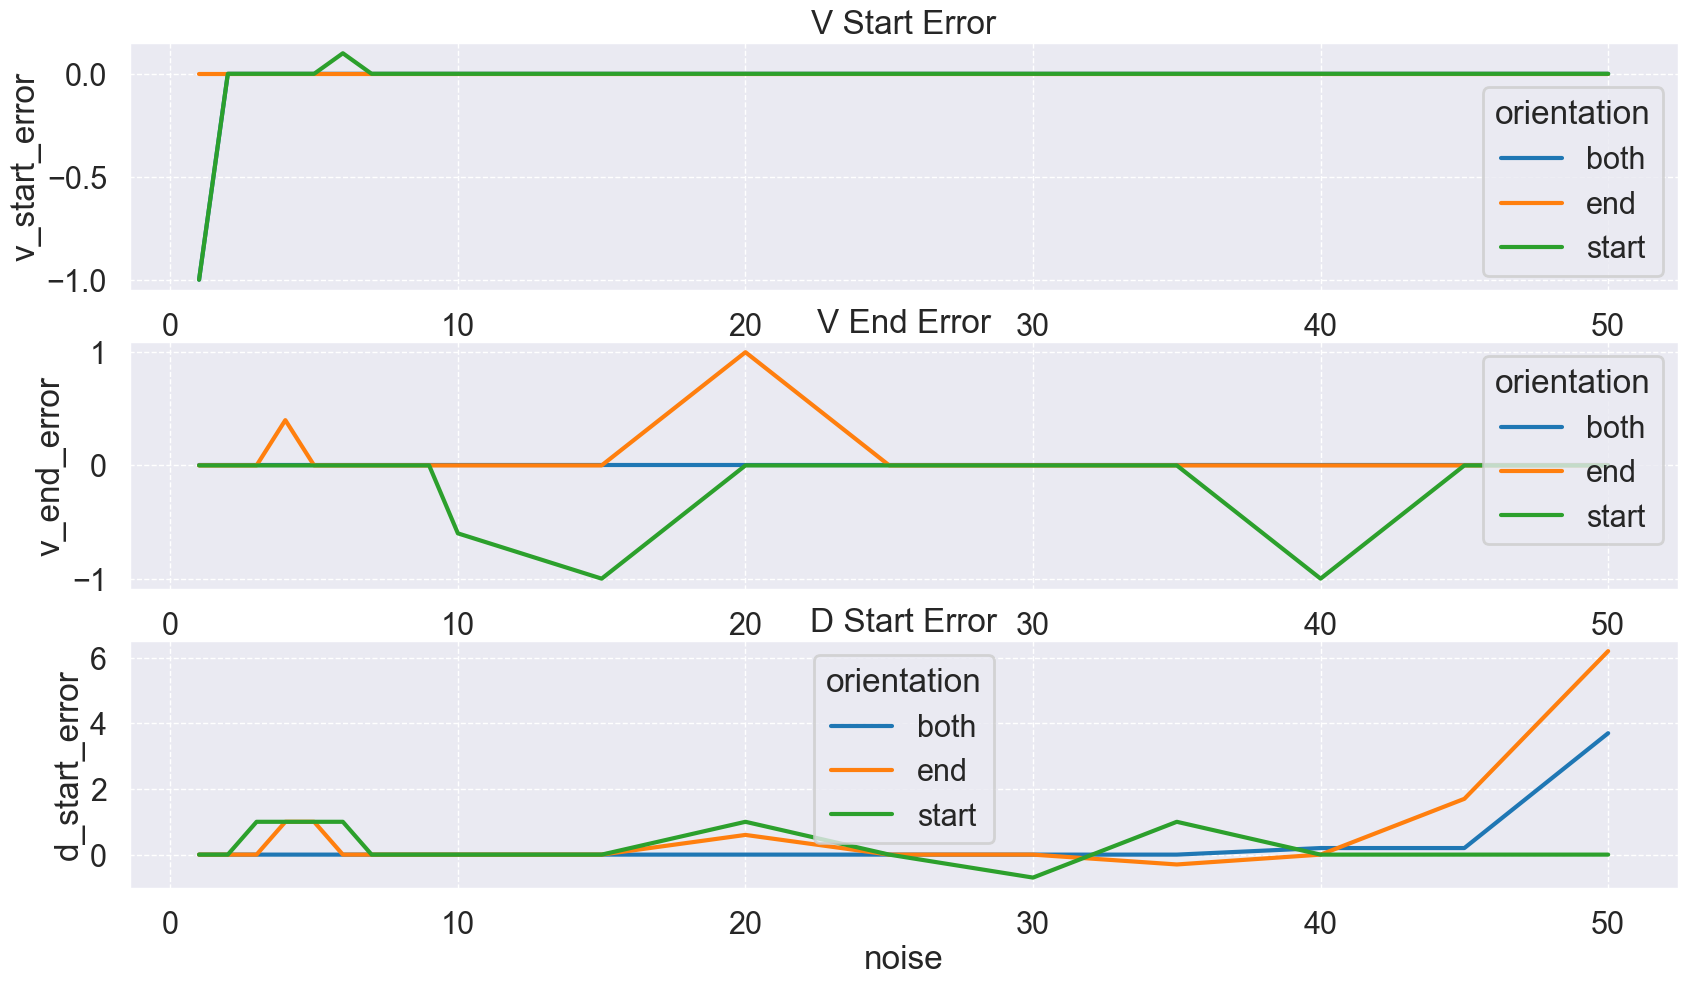

In [174]:
v_start_error = pdf['v_sequence_start'] - source_prediction.v_sequence_start
v_start_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
v_start_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

v_end_error = pdf['v_sequence_end'] - source_prediction.v_sequence_end
v_end_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
v_end_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']


d_start_error = pdf['d_sequence_start'] - source_prediction.d_sequence_start
d_start_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
d_start_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

d_end_error = pdf['d_sequence_end'] - source_prediction.d_sequence_end
d_end_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
d_end_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

j_start_error = pdf['j_sequence_start'] - source_prediction.j_sequence_start
j_start_error[orientation_ == 'start'] -= noise_[orientation_ == 'start']
j_start_error[orientation_ == 'both'] -= noise_[orientation_ == 'both']

# group by noise_
error_df = pd.DataFrame({
    'v_start_error':v_start_error,
    'v_end_error':v_end_error,
    'd_start_error':d_start_error,
    'd_end_error':d_end_error,
    'j_start_error':j_start_error,

    'noise':noise_,'orientation':orientation_,


                         }).groupby(['noise','orientation']).mean()

# plot lineplot noise level vs error per orientation
plt.subplot(3,1,1)
sns.lineplot(data=error_df,x='noise',y='v_start_error',hue='orientation')
plt.title('V Start Error')
plt.subplot(3,1,2)
sns.lineplot(data=error_df,x='noise',y='v_end_error',hue='orientation')
plt.title('V End Error')
plt.subplot(3,1,3)
sns.lineplot(data=error_df,x='noise',y='d_start_error',hue='orientation')
plt.title('D Start Error')
plt.show()

In [160]:
source_sample.v_sequence_end

296

## Adversarial Attack Model and Tests

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
import numpy as np

RANDOM_DIM = 32
ORIGINAL_SEQUENCE_LENGTH = len(source_sample.sequence)
MAX_PREFIX_LENGTH = 576 - ORIGINAL_SEQUENCE_LENGTH - 1
DNA_BASES = ['A', 'C', 'G', 'T','N','_']
INTEGER_TO_DNA = {i: DNA_BASES[i] for i in range(len(DNA_BASES))}

def translate_to_dna(integer_sequence):
    seq = []
    for i in integer_sequence:
        if INTEGER_TO_DNA[i] == '_':
            break
        seq.append(INTEGER_TO_DNA[i])
    return ''.join(seq)


class PrefixGenerator(tf.keras.Model):
    def __init__(self, max_prefix_len, vocab_size, hidden_dim=64):
        super().__init__()
        self.max_prefix_len = max_prefix_len
        self.vocab_size = vocab_size

        self.dense1 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.dense2 = tf.keras.layers.Dense(self.max_prefix_len * self.vocab_size)

    def call(self, z):
        """
        z: random noise or embedding [batch_size, random_dim]
        Returns: logits shape [batch_size, max_prefix_len, vocab_size]
        """
        h = self.dense1(z)
        h = self.dense2(h)
        # reshape to [batch_size, max_prefix_len, vocab_size]
        h = tf.reshape(h, [-1, self.max_prefix_len, self.vocab_size])
        return h

# Discrete sampling using categorical distribution (multinomial):
def sample_prefix(logits):
    """
    logits: [batch_size, max_len, vocab_size]
    Returns:
      prefix_tokens: [batch_size, max_len]
      log_probs:     [batch_size] (sum of log probs of chosen tokens)
    """
    batch_size = tf.shape(logits)[0]
    max_len = tf.shape(logits)[1]

    # 1) Flatten so we can sample for each position
    flat_logits = tf.reshape(logits, [batch_size*max_len, -1])  # shape: (batch_size*max_len, vocab_size)

    # 2) Sample exactly one token per position
    distribution = tf.random.categorical(flat_logits, num_samples=1)  # shape: (batch_size*max_len, 1)
    distribution = tf.cast(distribution, tf.int32)

    # Reshape to (batch_size, max_len)
    distribution = tf.reshape(distribution, [batch_size, max_len])

    # 3) Compute log_probs for each chosen token
    log_probs_all = tf.nn.log_softmax(logits, axis=-1)  # shape (batch_size, max_len, vocab_size)

    # Build the gather indices: shape (batch_size, max_len, 3)
    batch_indices = tf.range(batch_size, dtype=tf.int32)[:, tf.newaxis]     # (batch_size, 1)
    batch_indices = tf.tile(batch_indices, [1, max_len])                    # (batch_size, max_len)

    pos_indices = tf.range(max_len, dtype=tf.int32)[tf.newaxis, :]          # (1, max_len)
    pos_indices = tf.tile(pos_indices, [batch_size, 1])                     # (batch_size, max_len)

    # distribution is (batch_size, max_len)
    indices = tf.stack([batch_indices, pos_indices, distribution], axis=-1) # (batch_size, max_len, 3)

    chosen_log_probs = tf.gather_nd(log_probs_all, indices)  # shape (batch_size, max_len)
    sum_log_probs = tf.reduce_sum(chosen_log_probs, axis=1)  # shape (batch_size,)

    return distribution, sum_log_probs



DNA_BASES = ['A','C','G','T','N','_']
def int_seq_to_string(int_seq):
    return ''.join(DNA_BASES[i] for i in int_seq if i < len(DNA_BASES))


# We'll define the REINFORCE update manually:
def train_step(generator, optimizer, source_sequence, batch_size=4):
    # This function is now eager, not decorated with @tf.function

    # 1) Sample random noise
    z = tf.random.normal([batch_size, 32])

    with tf.GradientTape() as tape:
        # 2) Get logits from generator
        logits = generator(z)

        # 3) Sample discrete prefix
        prefix_tokens, log_probs = sample_prefix(logits)

        # 4) Convert prefix tokens to numpy
        print()
        prefix_tokens_np = prefix_tokens.numpy()  # This works in eager mode
        rewards = []
        for i in range(batch_size):
            prefix_str = translate_to_dna(prefix_tokens_np[i])
            full_seq = prefix_str + source_sequence.sequence

            # black-box predictor
            error_val = predictor.predict(full_seq)
            total_error = (error_val['v_sequence_start']
                           + error_val['v_sequence_end']
                           + error_val['d_sequence_start']
                           + error_val['d_sequence_end']
                           + error_val['j_sequence_start'])
            rewards.append(total_error)

        rewards = tf.constant(rewards, dtype=tf.float32)
        # REINFORCE loss
        loss = -tf.reduce_mean(rewards * log_probs)

    grads = tape.gradient(loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    return loss, tf.reduce_mean(rewards)




generator = PrefixGenerator(max_prefix_len=MAX_PREFIX_LENGTH, vocab_size=len(DNA_BASES))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Simple training loop
for step in range(100):
    loss_val, mean_reward = train_step(generator, optimizer, source_sample, batch_size=4)
    if step % 10 == 0:
        print(f"Step {step} | Loss: {loss_val.numpy():.3f} | MeanReward: {mean_reward.numpy():.3f}")

1/1 [==============================] - 0s 109ms/step


In [210]:
generated_length

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])